# Fondamenti di Analisi Dati - Spambase
## Rosario Scavo (1000037803)

The dataset can be downloaded from here:
http://archive.ics.uci.edu/dataset/94/spambase

## Table of Contents:
* [Dataset description](#data-description)
  * [Attribute description](#attribute-description)
* [Dataset Analysis](#data-analysis)
  * [Dataset integrity](#data-integrity)
  * [Descriptive statistics](#descriptive-statistics)
    * [Histogram distributions](#histograms-distribution)
    * [Word frequencies](#word-frequencies)
    * [Feature ratios](#feature-ratios)
    * [Hypothesis testing (chi-square test) on features](#hypothesis-testing)
  * [Outlier Analysis](#outlier-analysis)
    * [Word frequencies](#Word-frequencies)
    * [Character frequencies](#character-frequencies)
    * [Capital Run frequencies](#capital-run-frequencies)
    * [Interquartile Range (IQR) Analysis](#iqr)
  * [Multicollinearity](#multicollinearity)

# Dataset description <a id="data-description"></a>

The dataset includes various types of content that fall under the category of "spam", such as advertisements, chain letters, make-money-fast schemes, and pornography. The spam emails were collected from individuals who reported spam and the postmaster. On the other hand, non-spam emails were collected from personal and work files, where the presence of the word 'george' and the area code '650' were used as indicators of non-spam.

The central goal is to establish a classification rule to identify spam messages based on the frequency of specific words, numbers, characters, or consecutive capital letters in phrases. We will utilize various classification algorithms, including logistic regression (LR), Decision-Tree, and K-nearest neighbors algorithm (KNN), K-Means, to achieve this. These algorithms will be optimized through appropriate data preparation, transformation, and hyperparameter tuning using built-in Python functions. Additionally, we will determine the appropriate metrics to maximize and their impact on classification performance.

However, effective implementation requires thorough data analysis. Without prior data understanding, employing classifiers becomes challenging, if not impossible. This analysis will involve attribute exploration, variable type verification, missing value identification, feature-level metric analysis (mean, standard deviation, quantiles, etc.), feature importance determination for spam/non-spam classification, and outlier detection and analysis.

In [235]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import logit

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', RuntimeWarning)

In [117]:
names_list_filepath = 'spambase/names.txt'
attribute_names = []

with open(names_list_filepath, 'r') as file:
    attribute_names = file.read().splitlines()

data = pd.read_csv('spambase/spambase.data', names=attribute_names)
data

word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0               0.00               0.64           0.64           0.0   
1               0.21               0.28           0.50           0.0   
2               0.06               0.00           0.71           0.0   
3               0.00               0.00           0.00           0.0   
4               0.00               0.00           0.00           0.0   
...              ...                ...            ...           ...   
4596            0.31               0.00           0.62           0.0   
4597            0.00               0.00           0.00           0.0   
4598            0.30               0.00           0.30           0.0   
4599            0.96               0.00           0.00           0.0   
4600            0.00               0.00           0.65           0.0   

      word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0              0.32            0.00              0.00                0.00   
1              0.14            0.28              0.21                0.07   
2              1.23            0.19              0.19                0.12   
3              0.63            0.00              0.31                0.63   
4              0.63            0.00              0.31                0.63   
...             ...             ...               ...                 ...   
4596           0.00            0.31              0.00                0.00   
4597           0.00            0.00              0.00                0.00   
4598           0.00            0.00              0.00                0.00   
4599           0.32            0.00              0.00                0.00   
4600           0.00            0.00              0.00                0.00   

      word_freq_order  word_freq_mail  ...  char_freq_;  char_freq_(  \
0                0.00            0.00  ...        0.000        0.000   
1                0.00            0.94  ...        0.000        0.132   
2                0.64            0.25  ...        0.010        0.143   
3                0.31            0.63  ...        0.000        0.137   
4                0.31            0.63  ...        0.000        0.135   
...               ...             ...  ...          ...          ...   
4596             0.00            0.00  ...        0.000        0.232   
4597             0.00            0.00  ...        0.000        0.000   
4598             0.00            0.00  ...        0.102        0.718   
4599             0.00            0.00  ...        0.000        0.057   
4600             0.00            0.00  ...        0.000        0.000   

      char_freq_[  char_freq_!  char_freq_$  char_freq_#  \
0             0.0        0.778        0.000        0.000   
1             0.0        0.372        0.180        0.048   
2             0.0        0.276        0.184        0.010   
3             0.0        0.137        0.000        0.000   
4             0.0        0.135        0.000        0.000   
...           ...          ...          ...          ...   
4596          0.0        0.000        0.000        0.000   
4597          0.0        0.353        0.000        0.000   
4598          0.0        0.000        0.000        0.000   
4599          0.0        0.000        0.000        0.000   
4600          0.0        0.125        0.000        0.000   

      capital_run_length_average  capital_run_length_longest  \
0                          3.756                          61   
1                          5.114                         101   
2                          9.821                         485   
3                          3.537                          40   
4                          3.537                          40   
...                          ...                         ...   
4596                       1.142                           3   
4597                       1.555                           4   
4598                       1.404                      

## Attribute description <a id="attribute-description"></a>
- The last column of 'spambase.data' (**Class**) indicates whether the email was considered spam (1) or not (0), i.e., unsolicited commercial email.
- Most attributes indicate whether a specific word or character frequently occurs in the email.
- Attributes 55-57 (*run-length* attributes) measure the length of sequences of consecutive capital letters.

### Definitions of Attributes:
1. **48 continuous real [0,100] attributes of type `word_freq_WORD`:**
   - Percentage of words in the email that match the specified word. 
   - Calculation: $\frac{100 \times (\text{Number of times the word appears in the email})}{\text{Total number of words in the email}}$


2. **6 continuous real [0,100] attributes of type `char_freq_CHAR`:**
   - Percentage of characters in the email that match the specified character.
   - Calculation: 100 * (number of occurrences of the character) / total characters in the email.

3. **1 continuous real [1,...] attribute of type `capital_run_length_average`:**
   - Average length of uninterrupted sequences of capital letters.

4. **1 continuous integer [1,...] attribute of type `capital_run_length_longest`:**
   - Length of the longest uninterrupted sequence of capital letters.

5. **1 continuous integer [1,...] attribute of type `capital_run_length_total`:**
   - Sum of the length of uninterrupted sequences of capital letters.
   - Total number of capital letters in the email.

6. **1 nominal {0,1} class attribute of type `spam`:**
   - Denotes whether the email was considered spam (1) or not (0), i.e., unsolicited commercial email.


In [3]:
data.keys()

Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',


- **Number of instances:** 4601, of which 1813 are SPAM (39.4%)
- **Number of attributes:** 58 (57 continuous, 1 categorical representing the class label).

In [4]:
class_counts = data['Class'].value_counts()
print(class_counts)
print("\n")
data.info()

Class
0    2788
1    1813
Name: count, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non

# Dataset analysis <a id="data-analysis"></a>

## Dataset integrity <a id="data-integrity"></a>

Before analyzing the data, let's verify that the 'Class' attribute only contains the values 1 and 0. Additionally, we will check for any NaN values in the dataset.

In [5]:
data['Class'].unique()

array([1, 0])

In [6]:
count_nan_in_df = data.isnull().sum().sum()
print(f'Number of NaN values: {count_nan_in_df}')

Number of NaN values: 0


For simplicity, we will change the class type to bool and rename it to 'spam.' Consequently, when a record has `spam=True`, it indicates that the email is spam.

In [7]:
data['spam'] = data['Class'].astype(bool)
data = data.drop(columns=['Class'])
data['spam']

0        True
1        True
2        True
3        True
4        True
        ...  
4596    False
4597    False
4598    False
4599    False
4600    False
Name: spam, Length: 4601, dtype: bool

Utilizing the `describe` function's min and max lines, which provide insights into the minimum and maximum values for each column, we can confirm that the values of attributes indicating frequencies adhere to the established ranges. Specifically, the lower limit of the range is duly respected, while the upper limit is one unit higher due to the multiplication of frequencies by 100 (percentage), as explained earlier.

### Issue: Matrix Sparsity

However, a notable observation is that all quartile values are zero. This phenomenon arises from the inherent sparsity of the matrix, where numerous frequency-related values are zero in the majority of records. Consequently, the data is concentrated near zero, introducing noise that could potentially compromise the statistical analysis of the dataset.

To address this issue, in a later stage of the project, a decision was made to replace values equal to 0.0 with NaN for attributes indicating frequencies. This strategic move aimed to mitigate the impact of matrix sparsity, enhancing the dataset's suitability for robust statistical analysis.


In [8]:
data.describe()

word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
count     4601.000000        4601.000000    4601.000000   4601.000000   
mean         0.104553           0.213015       0.280656      0.065425   
std          0.305358           1.290575       0.504143      1.395151   
min          0.000000           0.000000       0.000000      0.000000   
25%          0.000000           0.000000       0.000000      0.000000   
50%          0.000000           0.000000       0.000000      0.000000   
75%          0.000000           0.000000       0.420000      0.000000   
max          4.540000          14.280000       5.100000     42.810000   

       word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
count    4601.000000     4601.000000       4601.000000         4601.000000   
mean        0.312223        0.095901          0.114208            0.105295   
std         0.672513        0.273824          0.391441            0.401071   
min         0.000000        0.000000          0.000000            0.000000   
25%         0.000000        0.000000          0.000000            0.000000   
50%         0.000000        0.000000          0.000000            0.000000   
75%         0.380000        0.000000          0.000000            0.000000   
max        10.000000        5.880000          7.270000           11.110000   

       word_freq_order  word_freq_mail  ...  word_freq_conference  \
count      4601.000000     4601.000000  ...           4601.000000   
mean          0.090067        0.239413  ...              0.031869   
std           0.278616        0.644755  ...              0.285735   
min           0.000000        0.000000  ...              0.000000   
25%           0.000000        0.000000  ...              0.000000   
50%           0.000000        0.000000  ...              0.000000   
75%           0.000000        0.160000  ...              0.000000   
max           5.260000       18.180000  ...             10.000000   

       char_freq_;  char_freq_(  char_freq_[  char_freq_!  char_freq_$  \
count  4601.000000  4601.000000  4601.000000  4601.000000  4601.000000   
mean      0.038575     0.139030     0.016976     0.269071     0.075811   
std       0.243471     0.270355     0.109394     0.815672     0.245882   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.065000     0.000000     0.000000     0.000000   
75%       0.000000     0.188000     0.000000     0.315000     0.052000   
max       4.385000     9.752000     4.081000    32.478000     6.003000   

       char_freq_#  capital_run_length_average  capital_run_length_longest  \
count  4601.000000                 4601.000000                 4601.000000   
mean      0.044238                    5.191515                   52.172789   
std       0.429342                   31.729449                  194.891310   
min       0.000000                    1.000000                    1.000000   
25%       0.000000                    1.588000                    6.000000   
50%       0.000000                    2.276000                   15.000000   
75%       0.000000                    3.706000                   43.000000   
max      19.829000                 1102.500000                 9989.000000   

       capital_run_length_total  
count               4601.000000  
mean                 283.289285  
std                  606.347851  
min                    1.000000  
25%                   35.000000  
50%                   95.000000  
75%                  266.000000  
max                15841.000000  

[8 rows x 57 columns]

In [9]:
data[data['spam'] == True].iloc[:, 0:-4].max()

word_freq_make           4.540
word_freq_address        4.760
word_freq_all            3.700
word_freq_3d            42.810
word_freq_our            7.690
word_freq_over           2.540
word_freq_remove         7.270
word_freq_internet      11.110
word_freq_order          3.330
word_freq_mail           7.550
word_freq_receive        2.610
word_freq_will           6.250
word_freq_people         5.550
word_freq_report         4.760
word_freq_addresses      4.410
word_freq_free          16.660
word_freq_business       7.140
word_freq_email          9.090
word_freq_you           12.500
word_freq_credit        18.180
word_freq_your          11.110
word_freq_font          17.100
word_freq_000            5.450
word_freq_money         12.500
word_freq_hp             3.580
word_freq_hpl            1.770
word_freq_george         1.280
word_freq_650            9.090
word_freq_lab            0.470
word_freq_labs           3.380
word_freq_telnet         1.360
word_freq_857            0.470
word_fre

In [10]:
data.iloc[:, :-4] /= 100
data.describe()

word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
count     4601.000000        4601.000000    4601.000000   4601.000000   
mean         0.001046           0.002130       0.002807      0.000654   
std          0.003054           0.012906       0.005041      0.013952   
min          0.000000           0.000000       0.000000      0.000000   
25%          0.000000           0.000000       0.000000      0.000000   
50%          0.000000           0.000000       0.000000      0.000000   
75%          0.000000           0.000000       0.004200      0.000000   
max          0.045400           0.142800       0.051000      0.428100   

       word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
count    4601.000000     4601.000000       4601.000000         4601.000000   
mean        0.003122        0.000959          0.001142            0.001053   
std         0.006725        0.002738          0.003914            0.004011   
min         0.000000        0.000000          0.000000            0.000000   
25%         0.000000        0.000000          0.000000            0.000000   
50%         0.000000        0.000000          0.000000            0.000000   
75%         0.003800        0.000000          0.000000            0.000000   
max         0.100000        0.058800          0.072700            0.111100   

       word_freq_order  word_freq_mail  ...  word_freq_conference  \
count      4601.000000     4601.000000  ...           4601.000000   
mean          0.000901        0.002394  ...              0.000319   
std           0.002786        0.006448  ...              0.002857   
min           0.000000        0.000000  ...              0.000000   
25%           0.000000        0.000000  ...              0.000000   
50%           0.000000        0.000000  ...              0.000000   
75%           0.000000        0.001600  ...              0.000000   
max           0.052600        0.181800  ...              0.100000   

       char_freq_;  char_freq_(  char_freq_[  char_freq_!  char_freq_$  \
count  4601.000000  4601.000000  4601.000000  4601.000000  4601.000000   
mean      0.000386     0.001390     0.000170     0.002691     0.000758   
std       0.002435     0.002704     0.001094     0.008157     0.002459   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000650     0.000000     0.000000     0.000000   
75%       0.000000     0.001880     0.000000     0.003150     0.000520   
max       0.043850     0.097520     0.040810     0.324780     0.060030   

       char_freq_#  capital_run_length_average  capital_run_length_longest  \
count  4601.000000                 4601.000000                 4601.000000   
mean      0.000442                    5.191515                   52.172789   
std       0.004293                   31.729449                  194.891310   
min       0.000000                    1.000000                    1.000000   
25%       0.000000                    1.588000                    6.000000   
50%       0.000000                    2.276000                   15.000000   
75%       0.000000                    3.706000                   43.000000   
max       0.198290                 1102.500000                 9989.000000   

       capital_run_length_total  
count               4601.000000  
mean                 283.289285  
std                  606.347851  
min                    1.000000  
25%                   35.000000  
50%                   95.000000  
75%                  266.000000  
max                15841.000000  

[8 rows x 57 columns]

## Descriptive statistics <a id="descriptive statistics"></a>

Emails can be categorized into two groups: spam and non-spam. To better understand these categories, it is important to calculate fundamental statistics for each group. Furthermore, we aim to pinpoint specific characteristics that could significantly influence the classification of an email.

In [11]:
spam = data[data['spam'] == True]
non_spam = data[data['spam'] == False]

In [12]:
spam.describe()

word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
count     1813.000000        1813.000000    1813.000000   1813.000000   
mean         0.001523           0.001646       0.004038      0.001647   
std          0.003106           0.003489       0.004807      0.022191   
min          0.000000           0.000000       0.000000      0.000000   
25%          0.000000           0.000000       0.000000      0.000000   
50%          0.000000           0.000000       0.003000      0.000000   
75%          0.001700           0.002100       0.006400      0.000000   
max          0.045400           0.047600       0.037000      0.428100   

       word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
count    1813.000000     1813.000000       1813.000000         1813.000000   
mean        0.005140        0.001749          0.002754            0.002081   
std         0.007072        0.003219          0.005721            0.005449   
min         0.000000        0.000000          0.000000            0.000000   
25%         0.000000        0.000000          0.000000            0.000000   
50%         0.002900        0.000000          0.000000            0.000000   
75%         0.007800        0.002400          0.003400            0.001900   
max         0.076900        0.025400          0.072700            0.111100   

       word_freq_order  word_freq_mail  ...  word_freq_conference  \
count      1813.000000     1813.000000  ...           1813.000000   
mean          0.001701        0.003505  ...              0.000021   
std           0.003548        0.006314  ...              0.000268   
min           0.000000        0.000000  ...              0.000000   
25%           0.000000        0.000000  ...              0.000000   
50%           0.000000        0.000000  ...              0.000000   
75%           0.001900        0.005100  ...              0.000000   
max           0.033300        0.075500  ...              0.007700   

       char_freq_;  char_freq_(  char_freq_[  char_freq_!  char_freq_$  \
count  1813.000000  1813.000000  1813.000000  1813.000000  1813.000000   
mean      0.000206     0.001090     0.000082     0.005137     0.001745   
std       0.000916     0.002821     0.000474     0.007442     0.003605   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000940     0.000000   
50%       0.000000     0.000650     0.000000     0.003310     0.000800   
75%       0.000000     0.001440     0.000000     0.006450     0.002110   
max       0.011170     0.097520     0.011710     0.078430     0.060030   

       char_freq_#  capital_run_length_average  capital_run_length_longest  \
count  1813.000000                 1813.000000                 1813.000000   
mean      0.000789                    9.519165                  104.393271   
std       0.006119                   49.846186                  299.284969   
min       0.000000                    1.000000                    1.000000   
25%       0.000000                    2.324000                   15.000000   
50%       0.000000                    3.621000                   38.000000   
75%       0.000180                    5.708000                   84.000000   
max       0.198290                 1102.500000                 9989.000000   

       capital_run_length_total  
count               1813.000000  
mean                 470.619415  
std                  825.081179  
min                    2.000000  
25%                   93.000000  
50%                  194.000000  
75%                  530.000000  
max                15841.000000  

[8 rows x 57 columns]

In [13]:
non_spam.describe()

word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
count     2788.000000        2788.000000    2788.000000   2788.000000   
mean         0.000735           0.002445       0.002006      0.000009   
std          0.002978           0.016332       0.005030      0.000213   
min          0.000000           0.000000       0.000000      0.000000   
25%          0.000000           0.000000       0.000000      0.000000   
50%          0.000000           0.000000       0.000000      0.000000   
75%          0.000000           0.000000       0.001200      0.000000   
max          0.043400           0.142800       0.051000      0.008700   

       word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
count    2788.000000     2788.000000       2788.000000         2788.000000   
mean        0.001810        0.000445          0.000094            0.000384   
std         0.006145        0.002229          0.001105            0.002472   
min         0.000000        0.000000          0.000000            0.000000   
25%         0.000000        0.000000          0.000000            0.000000   
50%         0.000000        0.000000          0.000000            0.000000   
75%         0.000000        0.000000          0.000000            0.000000   
max         0.100000        0.058800          0.030700            0.058800   

       word_freq_order  word_freq_mail  ...  word_freq_conference  \
count      2788.000000     2788.000000  ...           2788.000000   
mean          0.000380        0.001672  ...              0.000512   
std           0.001985        0.006432  ...              0.003652   
min           0.000000        0.000000  ...              0.000000   
25%           0.000000        0.000000  ...              0.000000   
50%           0.000000        0.000000  ...              0.000000   
75%           0.000000        0.000000  ...              0.000000   
max           0.052600        0.181800  ...              0.100000   

       char_freq_;  char_freq_(  char_freq_[  char_freq_!  char_freq_$  \
count  2788.000000  2788.000000  2788.000000  2788.000000  2788.000000   
mean      0.000503     0.001586     0.000227     0.001100     0.000116   
std       0.003034     0.002606     0.001349     0.008209     0.000696   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000645     0.000000     0.000000     0.000000   
75%       0.000000     0.002220     0.000000     0.000270     0.000000   
max       0.043850     0.052770     0.040810     0.324780     0.020380   

       char_freq_#  capital_run_length_average  capital_run_length_longest  \
count  2788.000000                 2788.000000                 2788.000000   
mean      0.000217                    2.377301                   18.214491   
std       0.002439                    5.113685                   39.084792   
min       0.000000                    1.000000                    1.000000   
25%       0.000000                    1.384000                    4.000000   
50%       0.000000                    1.857000                   10.000000   
75%       0.000000                    2.555000                   18.000000   
max       0.074070                  251.000000                 1488.000000   

       capital_run_length_total  
count               2788.000000  
mean                 161.470947  
std                  355.738403  
min                    1.000000  
25%                   18.750000  
50%                   54.000000  
75%                  141.000000  
max                 5902.000000  

[8 rows x 57 columns]

### Histograms distribution <a id="histograms-distribution"></a>

Histograms visually represent the distribution of values within each feature, providing valuable insights into the patterns and tendencies associated with spam and non-spam emails. By scrutinizing these histograms, one can discern any differences in the distributions, thereby gaining valuable insights into the characteristic features that distinguish spam from legitimate messages. For instance, when comparing `word_freq_business` with `word_freq_3d`, it is clear that the latter is a good feature for discriminating between spam and nonspam.

In [14]:
def plot_histogram(feature, spam, non_spam):
    plt.hist(spam[feature], bins=20, alpha=0.5, label='Spam')
    plt.hist(non_spam[feature], bins=20, alpha=0.5, label='Non-Spam')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature} for Spam and Non-Spam Emails')
    plt.legend()
    plt.show()

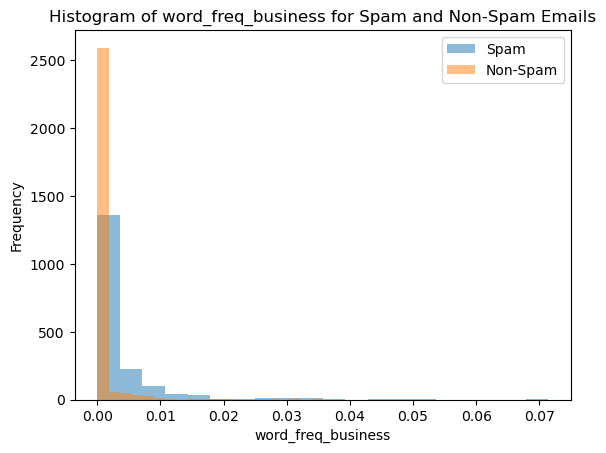

In [15]:
plot_histogram('word_freq_business', spam, non_spam)

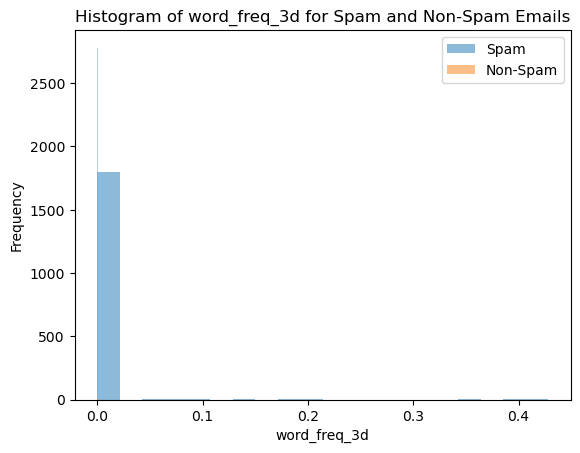

In [16]:
plot_histogram('word_freq_3d', spam, non_spam)

### Word frequencies <a id="word-frequencies"></a>

Certain columns showcase markedly higher maximum values within one class, in contrast with relatively lower values in the counterpart class. These observations provide valuable insights into potential discriminative features crucial for email classification.

In order to identify influential features impacting email classification, we scrutinize the features by averaging the values of the word frequencies and plotting them.

In [17]:
mean_wf = data.groupby('spam').mean()
mean_wr_fr = mean_wf.iloc[:, 0:-9]
nospam_wr_fr = mean_wr_fr.iloc[0]
spam_wr_fr = mean_wr_fr.iloc[1]

The initial graph presented here juxtaposes the average word frequency values in spam (depicted in orange) and non-spam emails (depicted in blue). Notably, certain words like "3d" (as shown previously) and "you" exhibit higher average frequencies in **SPAM emails**, while others like "hp," "address," "font," and "george" are more prevalent in **non-spam emails**. This suggests that the frequency of specific words plays a key role in email classification.

Following a similar approach, I extended the analysis to focus on the frequencies of special characters. It is commonly observed that non-spam emails tend to display a significant presence of such characters.

This comparative analysis provides valuable insights into the distinctive word and character frequency patterns between spam and non-spam emails, contributing to a better understanding of classification dynamics.


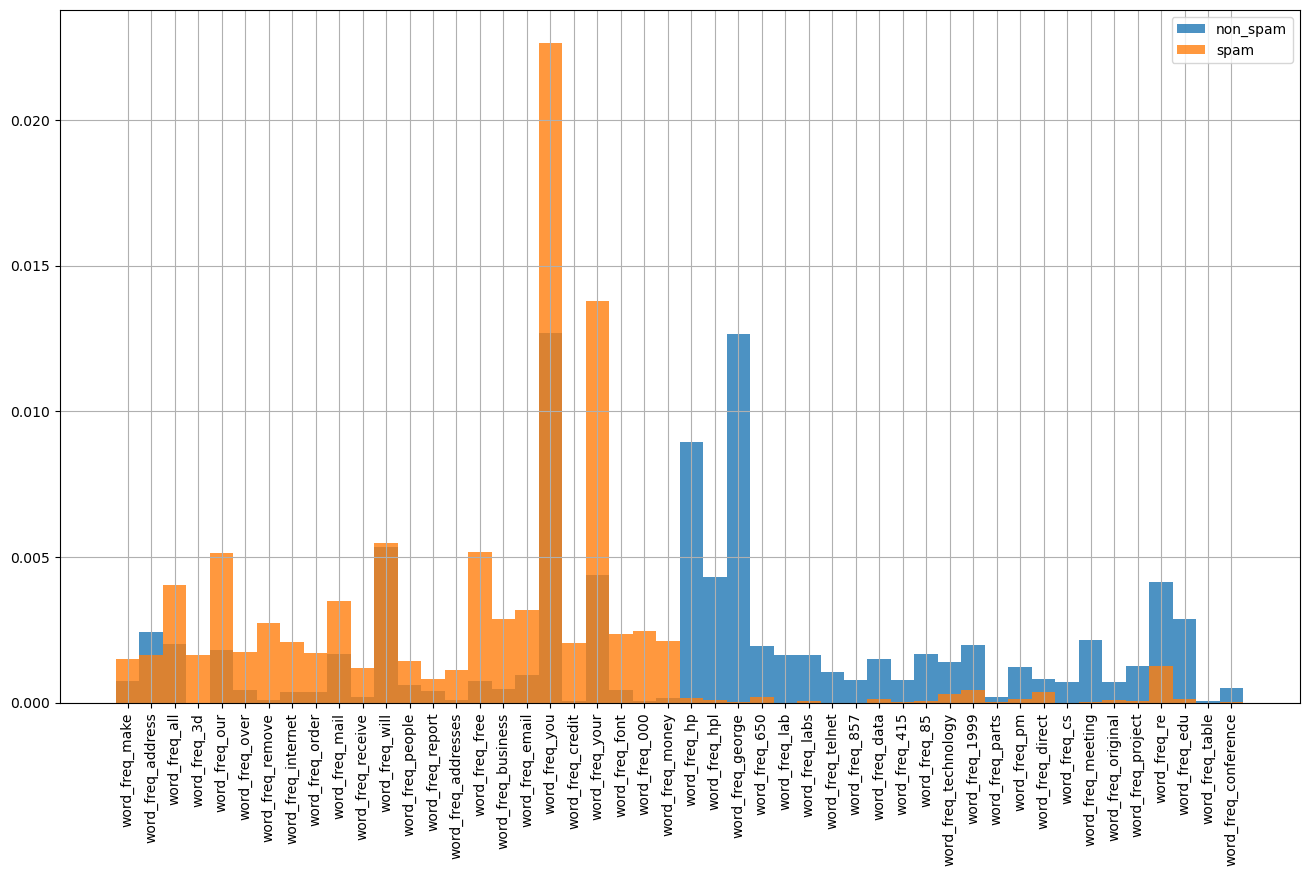

In [18]:
plt.figure(figsize=(16, 9))
plt.bar(nospam_wr_fr.index, nospam_wr_fr.values, width=1, alpha=0.8)
plt.bar(spam_wr_fr.index, spam_wr_fr.values, width=1, alpha=0.8)
plt.xticks(rotation='vertical')
plt.legend(['non_spam', 'spam'])
plt.grid()
plt.show()

### Feature ratios <a id="feature-ratios"></a>
In order to select influential features impacting email classification, we scrutinize the features by averaging the values within the Spambase dataset and assessing the ratios between spam and non-spam emails. We show only the features greater than the average of the ratio.

In [19]:
spam_mean = spam.mean()
non_spam_mean = non_spam.mean()
spam_diff = pd.concat(
    [spam_mean, non_spam_mean, spam_mean/non_spam_mean], axis=1)
# remove last row (spam column)
spam_diff = spam_diff[:-1]
spam_diff.columns = ['Spam', 'Non-Spam', 'Ratio']

spam_diff.sort_values(by='Ratio', ascending=False, inplace=True)

In [20]:
spam_diff_mean = spam_diff['Ratio'].mean()
selected_spam_diff = spam_diff[spam_diff['Ratio'] > spam_diff_mean]
selected_spam_diff

Spam  Non-Spam       Ratio
word_freq_3d         0.001647  0.000009  185.872477
word_freq_000        0.002471  0.000071   34.857704
word_freq_remove     0.002754  0.000094   29.351310
word_freq_credit     0.002055  0.000076   27.117520
char_freq_$          0.001745  0.000116   14.978608
word_freq_addresses  0.001121  0.000083   13.474663
word_freq_money      0.002129  0.000171   12.421667

We can plot the distribution of the ratios to have a better idea.

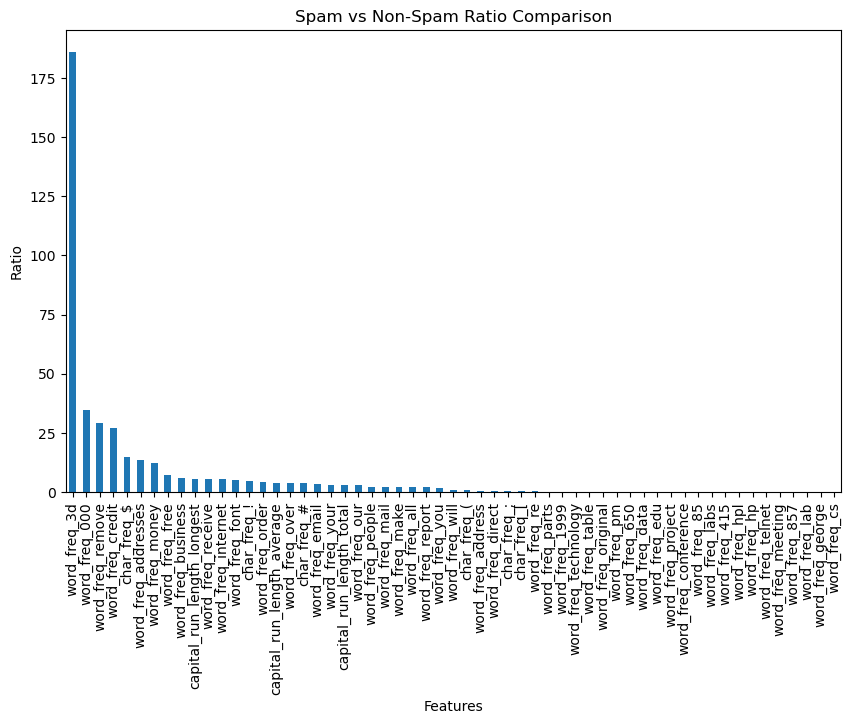

In [21]:
spam_diff['Ratio'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Features')
plt.ylabel('Ratio')
plt.title('Spam vs Non-Spam Ratio Comparison')
plt.show()

In [22]:
spam_indicators = list(selected_spam_diff.index.values)
spam_indicators.append('spam')
spam_indicators

['word_freq_3d',
 'word_freq_000',
 'word_freq_remove',
 'word_freq_credit',
 'char_freq_$',
 'word_freq_addresses',
 'word_freq_money',
 'spam']

Upon closer examination of certain word pairs, a discernible trend emerges: the joint appearance of both words in an email often suggests a higher likelihood of it being classified as spam. Furthermore, there is an intriguing correlation with word frequency, where a higher frequency is indicative of a higher likelihood of the email being categorized as spam.

In [23]:
%%warnings ignore

pair_spam = sns.pairplot(data[spam_indicators].iloc[::-1], hue="spam")
pair_spam.fig.suptitle('SPAM indicators', y=1.01, fontsize=20)

UsageError: Cell magic `%%warnings` not found.


#### Hypothesis testing (chi-square test) on features <a id="hypothesis-testing"></a>

The p-values obtained through the chi-square test serve as crucial indicators in understanding the relationship between the examined feature (independent variable) and the target variable 'spam.' The null hypothesis, in this context, posits no association or difference between the feature and the likelihood of an email being classified as spam.

##### Interpretation Guidelines:

- **Small p-value (e.g., < 0.05):**
  - **Conclusion:** Reject the null hypothesis.
  - **Implication:** Strong evidence exists, suggesting an association or difference between the feature and the 'spam' variable. The feature is likely to be statistically significant in predicting spam.

- **Large p-value (e.g., > 0.05):**
  - **Conclusion:** Fail to reject the null hypothesis.
  - **Implication:** Insufficient evidence to conclude an association or difference between the feature and the 'spam' variable. The feature may not be statistically significant in predicting spam.

A commonly used significance level (alpha) is 0.05. If a p-value is less than or equal to alpha, the null hypothesis is rejected. Careful consideration of these p-values allows the identification of features that play a significant role in predicting spam.

To calculate the p-values we can engage the **Chi-Square Test:**

The Chi-Square test is a statistical method used to determine if there is a significant association between two categorical variables. It compares the observed distribution of categorical data with the distribution that would be expected if the variables were independent. The test yields a p-value, indicating the probability of obtaining the observed distribution by chance.

**Formula:**

The Chi-Square test statistic (χ²) is calculated using the formula:

$$\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i} $$

where:
- $O_i$ is the observed frequency in each category,
- $E_i$ is the expected frequency in each category assuming independence.

The test compares the sum of squared differences between observed and expected frequencies, normalized by the expected frequencies. A higher Chi-Square value suggests a greater difference between observed and expected values, and a lower p-value indicates stronger evidence against the null hypothesis of independence.


In [24]:
p_values = {}
for column in data.columns[:-1]:
    contingency_table = pd.crosstab(data[column], data['spam'])
    _, p_value, _, _ = chi2_contingency(contingency_table)
    p_values[column] = round(p_value, 5)

In [25]:
pd.crosstab(data['capital_run_length_total'], data['spam'])

spam                      False  True 
capital_run_length_total              
1                             9      0
2                             8      5
3                            31      1
4                            46      1
5                           114      1
...                         ...    ...
9088                          0      1
9090                          0      1
9163                          0      1
10062                         0      1
15841                         0      1

[919 rows x 2 columns]

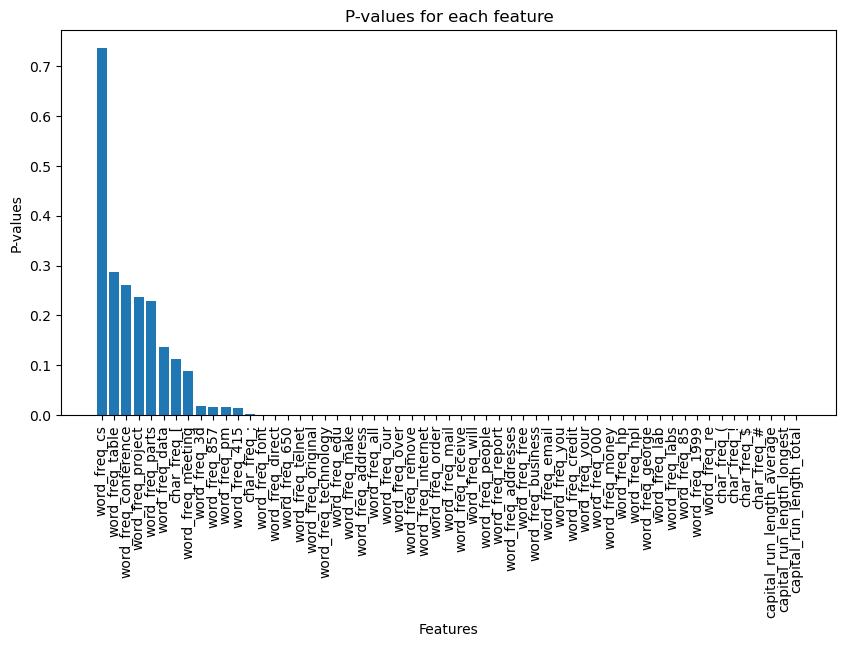

In [26]:
sorted_p_values = dict(
    sorted(p_values.items(), key=lambda item: float(item[1]), reverse=True))
keys = sorted_p_values.keys()
values = [float(v) for v in sorted_p_values.values()]

plt.figure(figsize=(10, 5))
plt.bar(keys, values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('P-values')
plt.title('P-values for each feature')
plt.show()

Features with Higher P-Values:

- **word_freq_cs (0.73532)**
- **word_freq_table (0.28752)**
- **word_freq_conference (0.25999)**
- **word_freq_project (0.23742)**
- **word_freq_parts (0.22839)**
- **word_freq_data (0.13572)**
- **char_freq_[ (0.11276)**
- **word_freq_meeting (0.08921)**

These results suggest that the mentioned features may not be as discriminatory in identifying spam emails compared to others. Notably, features selected previously as spam indicators, such as 'word_freq_3d,' 'word_freq_remove,' 'word_freq_addresses,' 'word_freq_credit,' 'word_freq_000,' 'word_freq_money,' and 'char_freq_$,' are conspicuously absent from the list. This absence indicates their potential efficacy as strong indicators of spam emails in the Spambase dataset.

In [27]:
p_value_threshold = 0.05
non_significant_indicators = {
    k: v for k, v in sorted_p_values.items() if v > p_value_threshold}
non_significant_indicators

{'word_freq_cs': 0.73532,
 'word_freq_table': 0.28752,
 'word_freq_conference': 0.25999,
 'word_freq_project': 0.23742,
 'word_freq_parts': 0.22839,
 'word_freq_data': 0.13572,
 'char_freq_[': 0.11276,
 'word_freq_meeting': 0.08921}

In [28]:
spam_indicators = spam_indicators[:-1]
spam_indicators

['word_freq_3d',
 'word_freq_000',
 'word_freq_remove',
 'word_freq_credit',
 'char_freq_$',
 'word_freq_addresses',
 'word_freq_money']

## Outlier Analysis <a id="outlier-analysis"></a>
In our exploration of the Spambase dataset, we aimed to identify outliers and understand their impact on the data. Initially, we plotted a boxplot for all the word frequency features, disregarding the distinction between spam and non-spam emails. This allowed us to observe the overall distribution of the data and identify potential outliers.

In [29]:
data_wr_fr = data.iloc[:, :-10]
data_char_freq = data.iloc[:, -10:-4]
data_capital_run = data.iloc[:, -4:-1]

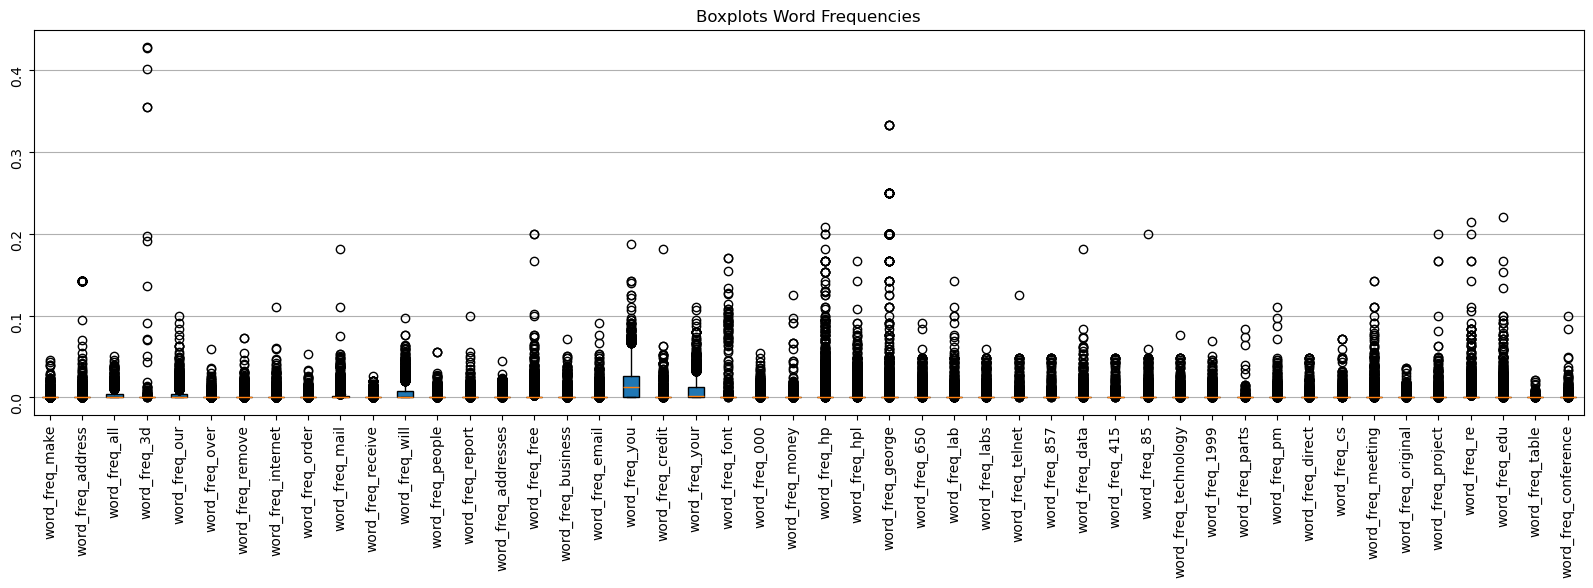

In [30]:
def draw_boxplot(ax, label, data):
    ax.boxplot(data,
               vert=True,
               patch_artist=True,
               labels=data.columns)
    ax.set_title(label)
    ax.yaxis.grid(True)
    ax.tick_params(labelrotation=90)

fig, ax = plt.subplots(figsize=(20, 5))
draw_boxplot(ax, 'Boxplots Word Frequencies', data_wr_fr)
plt.show()

### Word frequencies <a id="Word-frequencies"></a>
To gain a deeper understanding of outliers within each class, we opted to create separate boxplots for spam and non-spam emails. This more nuanced approach allows us to discern specific characteristics within each category and better comprehend the distinctions in outliers between spam and non-spam instances.

* **Symmetry Differences:**
   - The symmetry of the same feature differs between spam and non-spam classes. For instance, consider `word_freq_george`, a feature used to label non-spam emails. The asymmetry suggests that this feature may not exhibit similar behavior across both classes.

* **Distinctive Spam Features:**
   - Certain features, such as `word_freq_3d` and `word_freq_credit`, clearly stand out as potential indicators for classifying spam emails. These features demonstrate notable differences between spam and non-spam distributions, as previously stated.

* **Potential Non-Spam Indicators:**
   - In examining boxplots for non-spam emails, features like `word_freq_hp`, `word_freq_lab`, and `word_freq_meeting` emerge as potential indicators. Notably, non-spam distributions seem to harbor more outliers, suggesting potential discriminative power in these features.

* **Common Minimal Value:**
   - It's important to note that each boxplot has a minimum value of 0, reflecting the inherent nature of the features, which are always positive.

These insights derived from the boxplots contribute to a nuanced understanding of feature behaviors within spam and non-spam categories, aiding in the identification of key indicators for effective email classification.


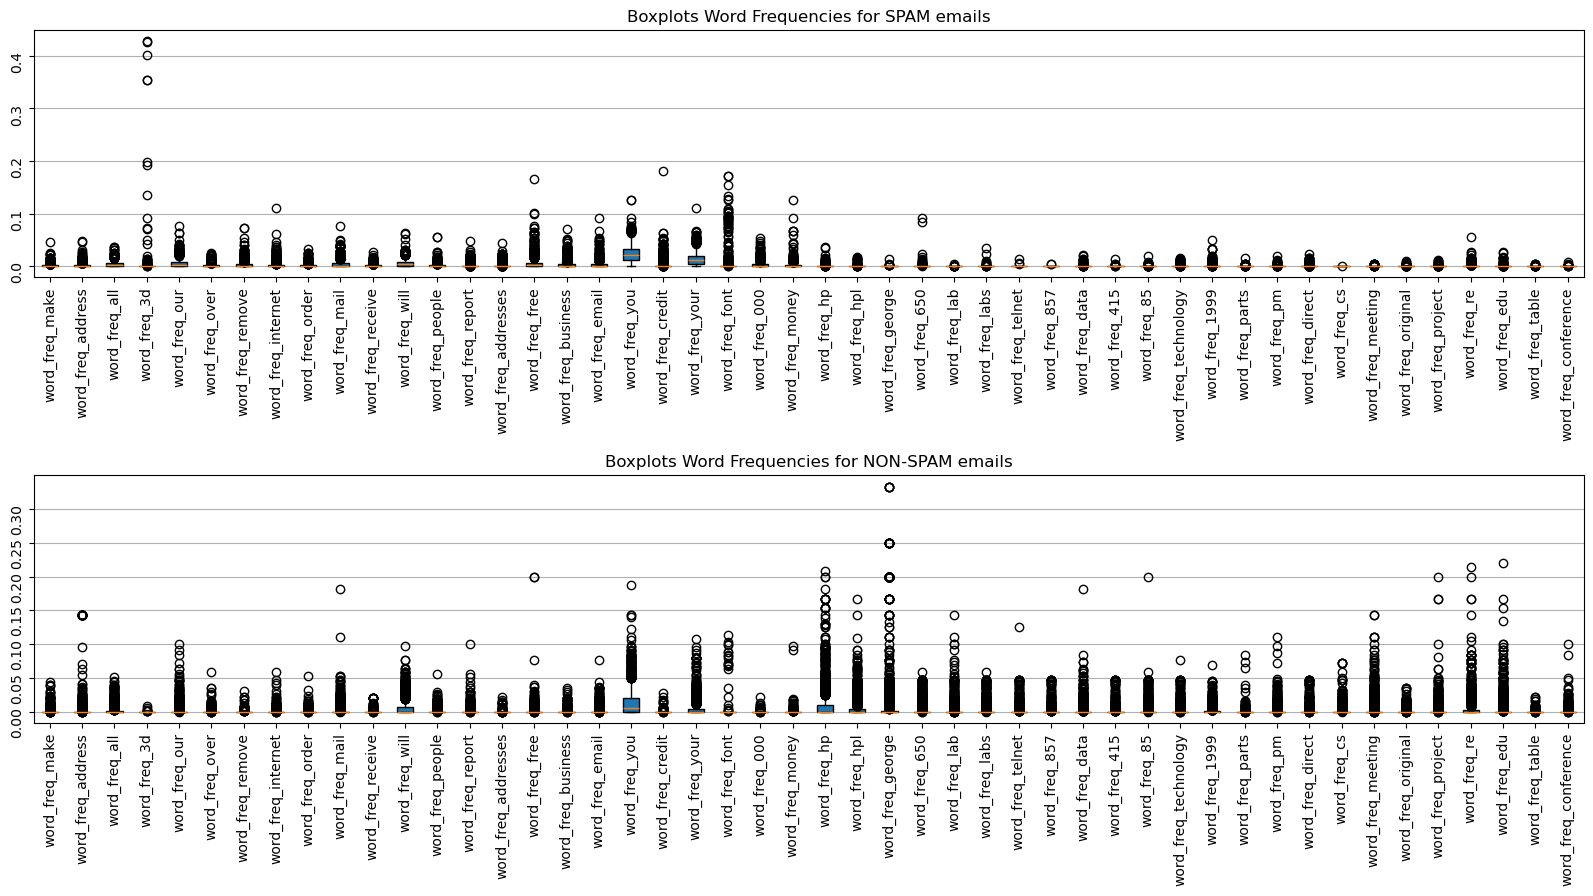

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 9))
draw_boxplot(ax1, 'Boxplots Word Frequencies for SPAM emails', data_wr_fr[data['spam']==True])
draw_boxplot(ax2, 'Boxplots Word Frequencies for NON-SPAM emails', data_wr_fr[data['spam']==False])
fig.subplots_adjust(hspace=0.8)
plt.show()

### Character frequencies <a id="character-frequencies"></a>

Observing the outlier distributions concerning the frequency of certain characters, notable distinctions emerge:

1. **`char_freq_$`:**
   - A noticeable difference in distribution is observed between spam and non-spam emails for `char_freq_$`. This discrepancy aligns with the common practice in spam emails, where fraudulent messages often involve mentions of free offerings (0$) or repetitive use of symbols like $$$.

2. **`char_freq_;`:**
   - Another significant feature is `char_freq_;`, which displays a correlation with non-spam emails beyond a certain frequency threshold. This correlation is logical as the presence of `;` is often associated with well-organized text (oppositely to this report :/)

##### General Observation on Outliers:

In summary, outliers in our dataset carry informative value and contribute to the classification process. Notably, features like `char_freq_$` and `char_freq_;` showcase distinctive patterns between spam and non-spam emails. Consequently, the decision has been made not to remove any outliers from our data.

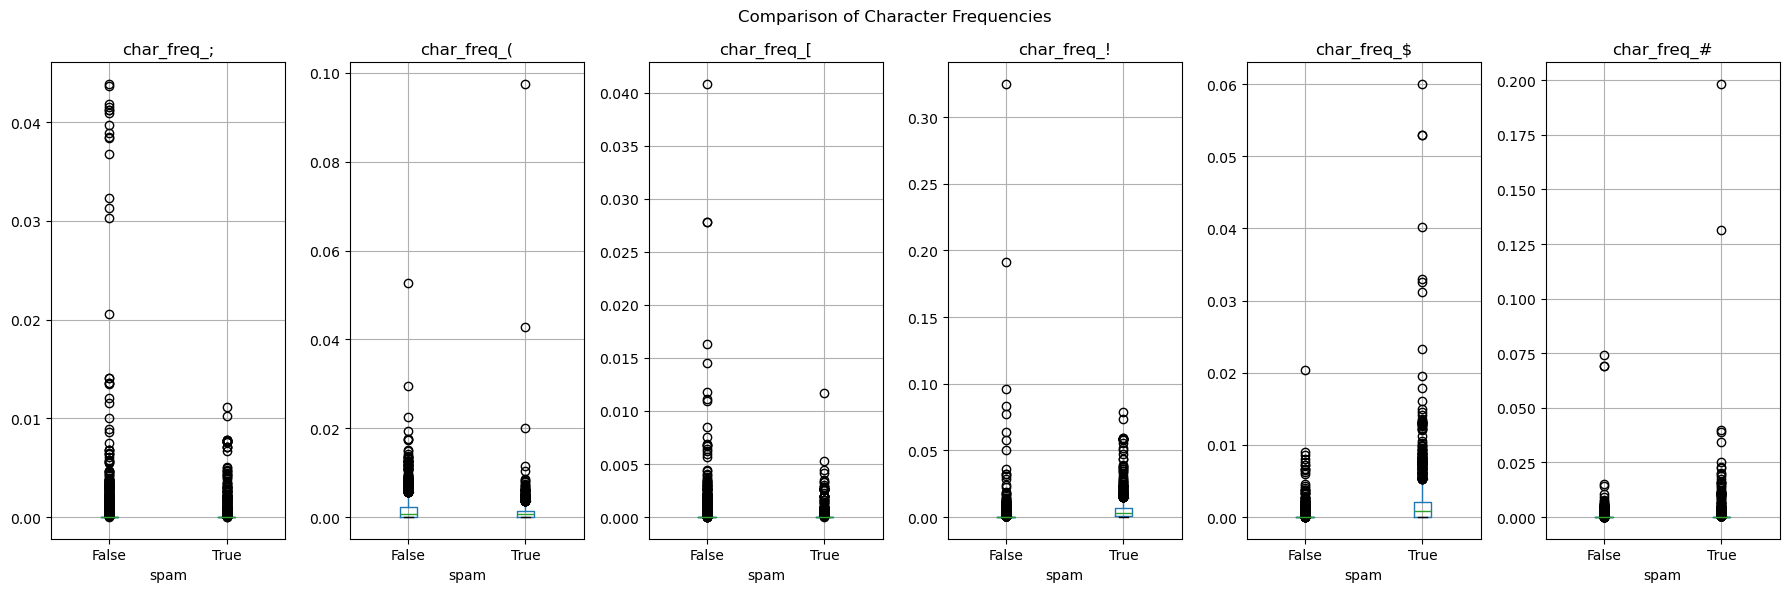

In [32]:
char_freq_cols = data_char_freq.columns
fig, axes = plt.subplots(1, len(char_freq_cols), figsize=(18, 6))

for i, col in enumerate(char_freq_cols):
    data.boxplot(by='spam', column=col, ax=axes[i])
    axes[i].set_title(col)
    
fig.suptitle('Comparison of Character Frequencies')
plt.tight_layout()
plt.show()

### Capital Run frequencies <a id="capital-run-frequencies"></a>
We also investigated the role of capital letters in distinguishing between spam and non-spam emails. Notably, the feature `capital_run_length_average` caught our interest, as it represents the average length of consecutive sequences of capital letters in an email. This metric proved to be a valuable indicator, showcasing a higher average presence of consecutive capital letters in spam emails compared to non-spam counterparts.

Upon visualizing the data, we observed that spam emails exhibit a tendency towards longer consecutive sequences of capital letters, suggesting a potential pattern that could aid in classification.

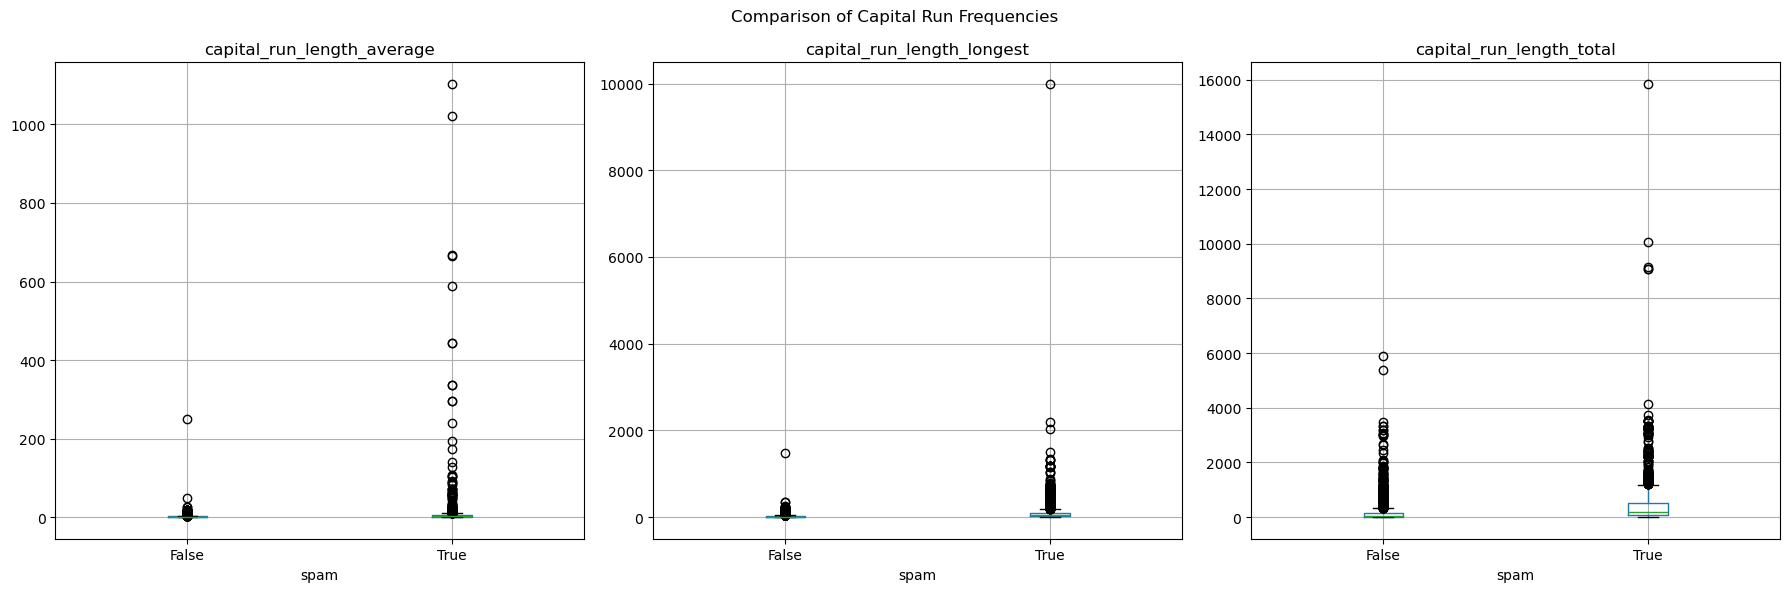

In [33]:
data_capital_run = data_capital_run.columns
fig, axes = plt.subplots(1, len(data_capital_run), figsize=(18, 6))

for i, col in enumerate(data_capital_run):
    data.boxplot(by='spam', column=col, ax=axes[i])
    axes[i].set_title(col)
    
fig.suptitle('Comparison of Capital Run Frequencies')
plt.tight_layout()
plt.show()

### Interquartile Range (IQR) Analysis <a id="iqr"></a>

The Interquartile Range (IQR) serves as a crucial measure of statistical dispersion, representing the range between the first quartile (Q1) and the third quartile (Q3) within a dataset. It provides insights into the spread of the middle 50% of the data.

#### Interpreting the Values:
- Each column in `iqr_df` corresponds to a feature from the dataset.
- A larger IQR suggests a greater variability in the middle 50% of the data for a specific feature.
- A small IQR indicates that the central portion of the data is concentrated in a narrow range.
- By comparing IQR values between "spam" and "non_spam," we can identify features where the spread of data significantly differs for the two categories.

#### Example Interpretation:

For instance, if `iqr_df` indicates that the IQR for feature X is substantially larger in the "spam" category compared to the "nospam" category, it suggests that the spread of values for feature X is more diverse among spam instances.

This IQR analysis provides valuable insights into the distributional differences within numerical features, aiding in the identification of characteristics that may contribute to the classification of spam and non-spam instances.

In [34]:
columns = data.iloc[:, :-1].columns
spam_iqr = []
non_spam_iqr = []
for col in columns:
    spam_q1,spam_q3 = data[data['spam']==True][col].quantile([1/4,3/4])
    non_spam_q1, non_spam_q3 = data[data['spam']==False][col].quantile([1/4,3/4])
    spam_iqr.append(spam_q3-spam_q1)
    non_spam_iqr.append(non_spam_q3-non_spam_q1)

iqr_df = pd.DataFrame([spam_iqr, non_spam_iqr], columns=columns, index=["spam", "non_spam"])
iqr_df

word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
spam              0.0017             0.0021         0.0064           0.0   
non_spam          0.0000             0.0000         0.0012           0.0   

          word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
spam             0.0078          0.0024            0.0034              0.0019   
non_spam         0.0000          0.0000            0.0000              0.0000   

          word_freq_order  word_freq_mail  ...  word_freq_conference  \
spam               0.0019          0.0051  ...                   0.0   
non_spam           0.0000          0.0000  ...                   0.0   

          char_freq_;  char_freq_(  char_freq_[  char_freq_!  char_freq_$  \
spam              0.0      0.00144          0.0      0.00551      0.00211   
non_spam          0.0      0.00222          0.0      0.00027      0.00000   

          char_freq_#  capital_run_length_average  capital_run_length_longest  \
spam          0.00018                       3.384                        69.0   
non_spam      0.00000                       1.171                        14.0   

          capital_run_length_total  
spam                        437.00  
non_spam                    122.25  

[2 rows x 57 columns]

The observed values in our analysis further confirm the earlier assertions regarding features that appear to be particularly informative in discerning between spam and non-spam emails. Notably, features such as `capital_run_length_total,` `word_freq_free,` and others exhibit noticeable distinctions in their Interquartile Range (IQR) values when stratified by the spam and non-spam classes.

The IQR, a measure of statistical dispersion, provides insight into the data spread within each class. The discernible differences in IQR values between spam and non-spam instances for specific features suggest that these variables carry significant discriminatory potential. For instance, `capital_run_length_total` indicates a variance in the total length of consecutive capital letters, while `word_freq_free` reflects the frequency of the word "free" in the email.

These findings reinforce the hypothesis that certain features possess inherent patterns or characteristics that contribute significantly to classifying emails into spam or non-spam categories.

In [35]:
iqr_df.loc['abs_diff'] = abs(iqr_df.loc["non_spam"] - iqr_df.loc["spam"])
iqr_df_transposed = iqr_df.T
iqr_df_transposed[iqr_df_transposed['abs_diff']>0].sort_values(by='abs_diff', ascending=False)

spam    non_spam    abs_diff
capital_run_length_total    437.00000  122.250000  314.750000
capital_run_length_longest   69.00000   14.000000   55.000000
capital_run_length_average    3.38400    1.171000    2.213000
word_freq_your                0.01490    0.004600    0.010300
word_freq_hp                  0.00000    0.010000    0.010000
word_freq_our                 0.00780    0.000000    0.007800
word_freq_free                0.00640    0.000000    0.006400
char_freq_!                   0.00551    0.000270    0.005240
word_freq_all                 0.00640    0.001200    0.005200
word_freq_mail                0.00510    0.000000    0.005100
word_freq_email               0.00390    0.000000    0.003900
word_freq_remove              0.00340    0.000000    0.003400
word_freq_business            0.00340    0.000000    0.003400
word_freq_000                 0.00340    0.000000    0.003400
word_freq_hpl                 0.00000    0.003300    0.003300
word_freq_money               0.00290    0.000000    0.002900
word_freq_re                  0.00050    0.003125    0.002625
word_freq_over                0.00240    0.000000    0.002400
char_freq_$                   0.00211    0.000000    0.002110
word_freq_address             0.00210    0.000000    0.002100
word_freq_order               0.00190    0.000000    0.001900
word_freq_internet            0.00190    0.000000    0.001900
word_freq_make                0.00170    0.000000    0.001700
word_freq_people              0.00170    0.000000    0.001700
word_freq_george              0.00000    0.001625    0.001625
word_freq_receive             0.00140    0.000000    0.001400
word_freq_1999                0.00000    0.001000    0.001000
word_freq_will                0.00840    0.007525    0.000875
char_freq_(                   0.00144    0.002220    0.000780
word_freq_you                 0.02050    0.019925    0.000575
char_freq_#                   0.00018    0.000000    0.000180

## Multicollinearity <a id="multicollinearity"></a>

Before starting with the classification methods, as we studied the subject, we should address a potential issue in our dataset: **multicollinearity**. Multicollinearity occurs when independent variables in a multiple regression model display high correlations among themselves. This correlation between independent variables (our features) can pose challenges in distinguishing the individual effects of these features on the dependent variable (the class of the email, spam, or non-spam). In such cases, we can try to remove the correlated variables (we can identify correlated variables with the `correlation matrix`, by plotting an heatmap), apply some feature selection method or perform Principal Component Analysis (PCA).

## Analyzing Correlations in the Spambase Dataset

In this analysis of the Spambase dataset, we aim to uncover potential relationships and dependencies between different parameters by utilizing a correlation matrix. A correlation matrix is a tabular representation of correlation coefficients between variables in a dataset. The correlation coefficient quantifies the strength and direction of a linear relationship between two variables. In this specific investigation, we choose to employ the Kendall correlation coefficient as opposed to Pearson, considering the presence of outliers in the dataset. The **Kendall correlation coefficient** is particularly robust in scenarios with outliers and non-normally distributed data. It measures the strength of dependence between two variables by comparing the number of concordant and discordant pairs of observations. The formula for calculating the Kendall correlation coefficient, denoted as $\tau$, is as follows:

$$\tau = \frac{{\text{{Number of concordant pairs}} - \text{{Number of discordant pairs}}}}{{\text{{Total number of pairs}}}}$$

Here, concordant pairs are those with the same order of ranks in both variables, while discordant pairs have different orderings. By employing the Kendall correlation coefficient, we aim to gain insights into potential associations among the parameters in the Spambase dataset while accounting for its unique characteristics, including the presence of outliers.

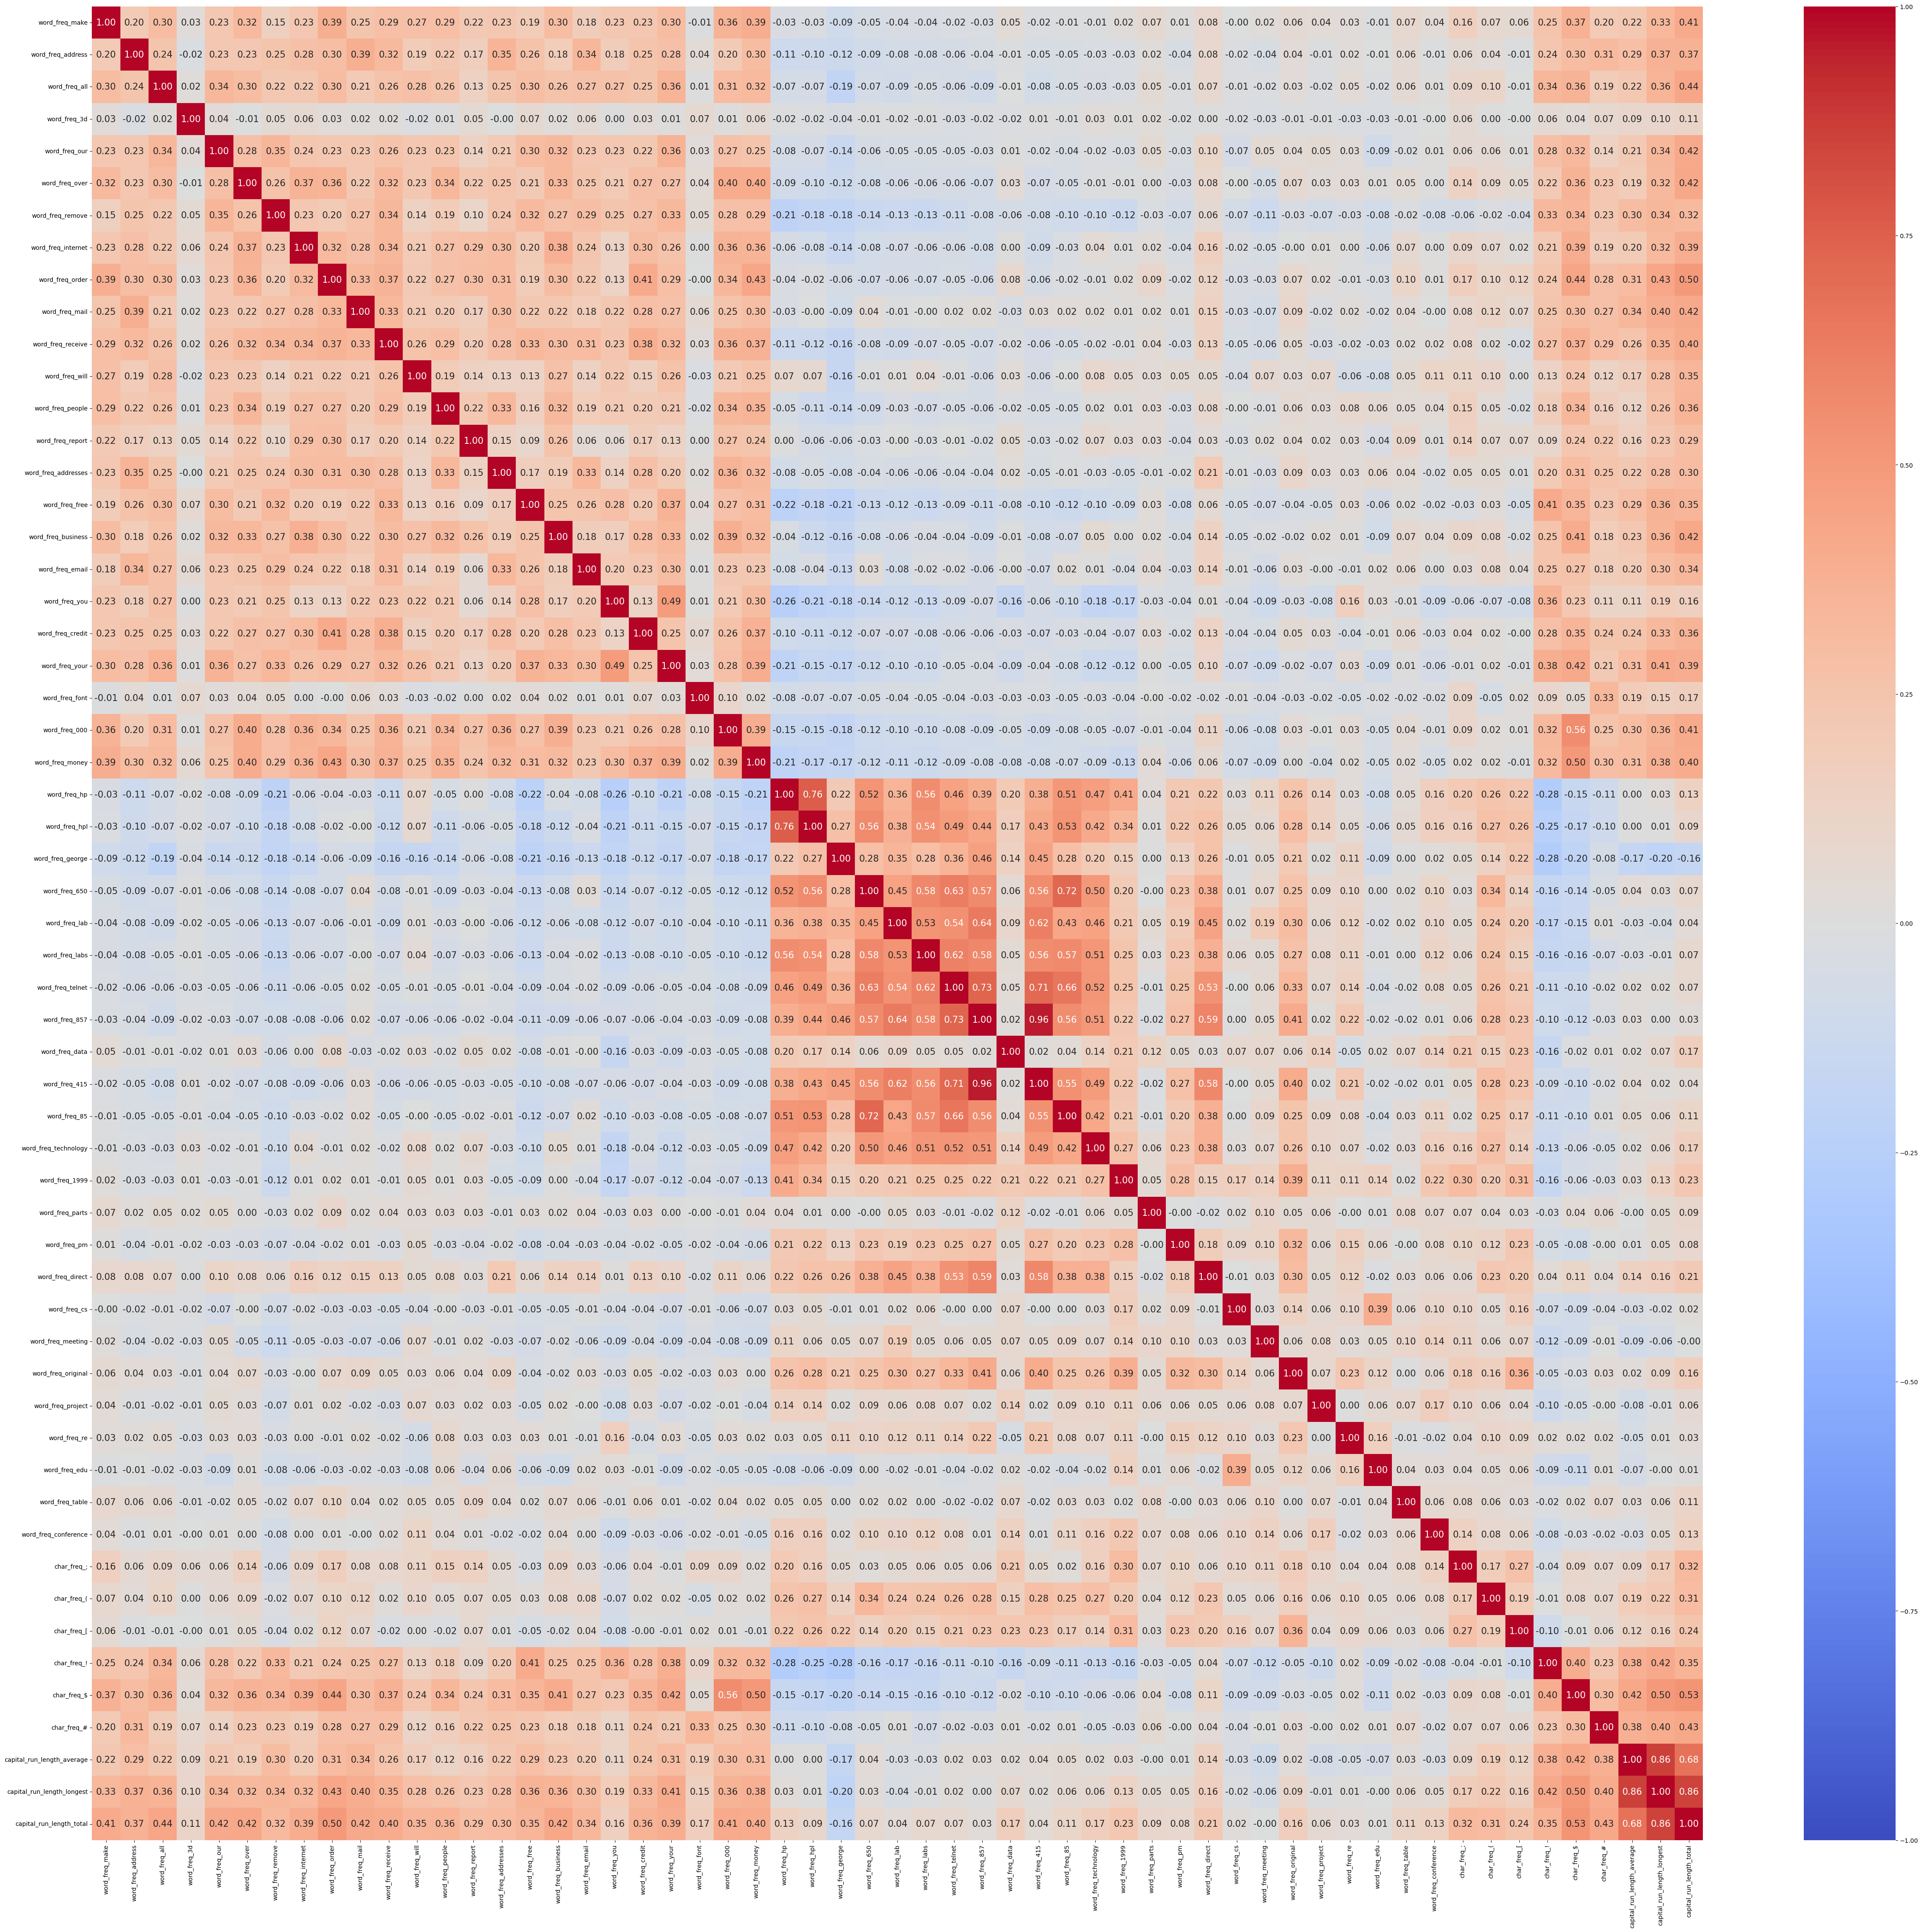

In [39]:
import seaborn as sns

new_df = data.iloc[:, :-1].copy()

plt.rcParams.update({'figure.figsize':(60,55), 'figure.dpi':100})

correlation_matrix = new_df.corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", vmin=-1, vmax=1, cbar=True, cmap='coolwarm', annot_kws={'size': 15})
plt.show()

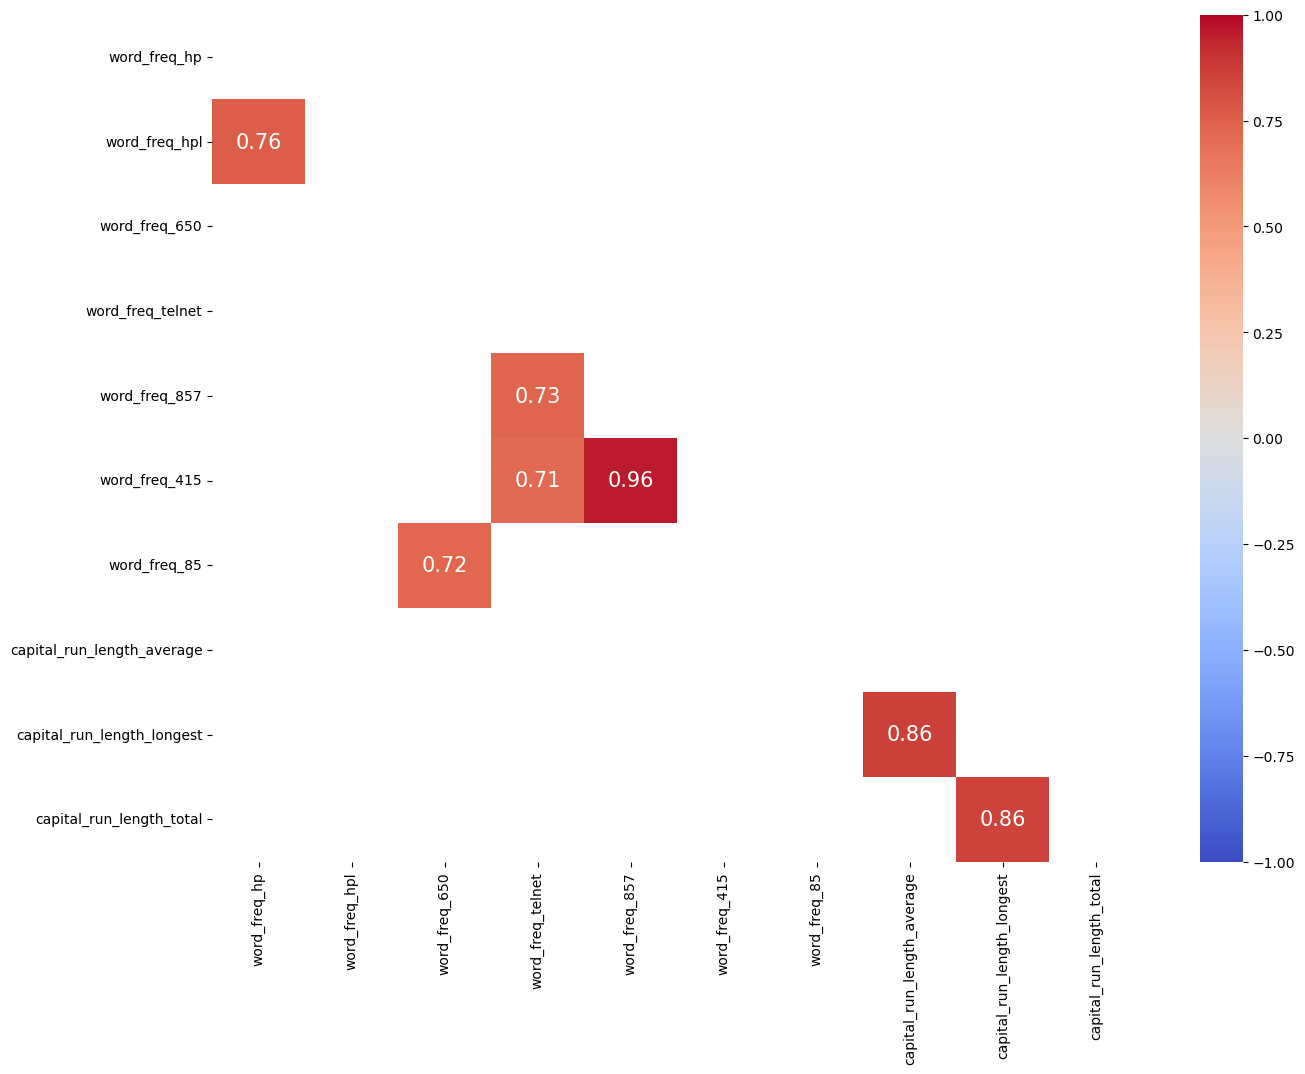

In [84]:
threshold = 0.7
high_corr = correlation_matrix[abs(correlation_matrix) > threshold]
np.fill_diagonal(high_corr.values, np.nan)
mask = np.triu(np.ones_like(high_corr, dtype=bool))
inverse_mask = ~mask

high_corr_masked = high_corr * inverse_mask
high_corr_masked.dropna(how='all', axis=1, inplace=True)
high_corr_masked.dropna(how='all', axis=0, inplace=True)

mask = np.triu(np.ones_like(high_corr_masked, dtype=bool))

plt.rcParams.update({'figure.figsize':(15,11), 'figure.dpi':100})

sns.heatmap(high_corr_masked, mask=mask, annot=True, fmt=".2f", vmin=-1, vmax=1, cbar=True, cmap='coolwarm', annot_kws={'size': 15})
plt.show()

We can decide to remove
* word_freq_hpl since it is correlated with word_freq_hp
* word_freq_telnet since it is correlated with word_freq_857 and word_freq_415
* word_freq_857 since it is correlated with word_freq_415
* word_freq_85 since it is correlated with word_freq_650
* capital_run_length_longest since it is correlated with capital_run_length_average

In [253]:
high_corr_attributes = ['word_freq_hpl', 'word_freq_telnet', 'word_freq_857', 'word_freq_85', 'capital_run_length_longest']

## Classification Algorithms <a id="cls_algo"></a>

In [256]:
names_list_filepath = 'spambase/names.txt'
attribute_names = []

with open(names_list_filepath, 'r') as file:
    attribute_names = file.read().splitlines()

data = pd.read_csv('spambase/spambase.data', names=attribute_names)

data.iloc[:, :-4] /= 100

In [257]:
column_name_mapping = {'char_freq_;':'char_freq_semicolon',
                       'char_freq_(':'char_freq_round_bracket', 
                       'char_freq_[':'char_freq_square_bracket', 
                       'char_freq_!':'char_freq_exclamation',
                       'char_freq_#':'char_freq_hash',
                       'char_freq_$':'char_freq_dollar',
                       'Class':'spam'}

data.rename(columns=column_name_mapping, inplace=True)
data_attributes = data.columns.tolist()[:-1]

random_state : int, RandomState instance or None, default=None
    Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls.

In [277]:
email_train, email_test = train_test_split(data, test_size=0.25, random_state=0)

formula = "spam ~ " + " + ".join(data_attributes)

model = logit(formula, email_train).fit()
summary = model.summary()
summary

         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

let's try to remove the high correlated attributed we found before with the Kendall correlation coefficient

In [278]:
high_corr_attributes
data_attributes_no_corr = [attr for attr in data_attributes if attr not in high_corr_attributes]

In [279]:
email_train, email_test = train_test_split(data, test_size=0.25, random_state=0)

formula = "spam ~ " + " + ".join(data_attributes_no_corr)

model = logit(formula, email_train).fit()
summary = model.summary()
summary

         Current function value: 0.187157
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   spam   No. Observations:                 3450
Model:                          Logit   Df Residuals:                     3397
Method:                           MLE   Df Model:                           52
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                  0.7205
Time:                        21:34:48   Log-Likelihood:                -645.69
converged:                      False   LL-Null:                       -2310.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.8215      0.167    -10.923      0.000      -2.148      -1.495
word_freq_make               -45.4364     27.856     -1.631      0.103    -100.033       9.160
word_freq_address            -11.2960      8.086     -1.397      0.162     -27.143       4.551
word_freq_all                 22.2041     14.407      1.541      0.123      -6.034      50.442
word_freq_3d                 188.9055    141.728      1.333      0.183     -88.877     466.688
word_freq_our                 74.6857     14.184      5.265      0.000      46.885     102.486
word_freq_over                87.0471     29.119      2.989      0.003      29.975     144.119
word_freq_remove             236.9795     39.456      6.006      0.000     159.647     314.312
word_freq_internet            45.5503     15.609      2.918      0.004      14.958      76.142
word_freq_order               76.2801     38.573      1.978      0.048       0.679     151.881
word_freq_mail                 2.2032      7.645      0.288      0.773     -12.782      17.188
word_freq_receive             12.3526     37.611      0.328      0.743     -61.364      86.069
word_freq_will               -12.7096      8.412     -1.511      0.131     -29.196       3.777
word_freq_people               7.2314     29.409      0.246      0.806     -50.409      64.871
word_freq_report              20.8883     16.436      1.271      0.204     -11.325      53.102
word_freq_addresses           86.8922     71.429      1.216      0.224     -53.107     226.891
word_freq_free               108.4484     17.778      6.100      0.000      73.605     143.292
word_freq_business            93.3197     25.837      3.612      0.000      42.681     143.959
word_freq_email                0.9827     13.957      0.070      0.944     -26.372      28.337
word_freq_you                 11.2640      4.127      2.729      0.006       3.175      19.353
word_freq_credit             159.7084     89.855      1.777      0.076     -16.404     335.821
word_freq_your                29.1681      6.604      4.417      0.000      16.225      42.111
word_freq_font                15.2619     19.085      0.800      0.424     -22.143      52.667
word_freq_000                217.2654     52.468      4.141      0.000     114.430     320.101
word_freq_money               37.2177     15.865      2.346      0.019       6.123      68.312
word_freq_hp                -268.1836     37.433     -7.164      0.000    -341.551    -194.816
word_freq_george           -1946.4215    319.258     -6.097      0.000   -2572.155   -1320.688
word_freq_650                 53.0517     28.887      1.836      0.066      -3.567     109.670
word_freq_lab               -231.6616    155.425     -1.491      0.136    -536.288      72.965
word_freq_labs               -58.6854     47.956     -1.224      0.221    -152.677      35.306
word_freq_data              -125.9851     45.157     -2.790      0.005    -214.491     -37.479
word_freq_4

Use only low p-value attributes:

In [287]:
p_values = model.pvalues
if 'Intercept' in p_values.index:
    p_values.drop('Intercept', inplace=True)
    
ordered_p_values = p_values.sort_values(ascending=False).round(3)

useful_p_values = ordered_p_values[ordered_p_values < 0.05]
useful_attributes = useful_p_values.index.tolist()

useful_attributes

['word_freq_order',
 'word_freq_pm',
 'word_freq_project',
 'word_freq_money',
 'word_freq_conference',
 'char_freq_hash',
 'char_freq_semicolon',
 'word_freq_you',
 'word_freq_meeting',
 'word_freq_data',
 'word_freq_415',
 'word_freq_internet',
 'word_freq_over',
 'word_freq_technology',
 'word_freq_business',
 'char_freq_exclamation',
 'word_freq_000',
 'word_freq_your',
 'word_freq_re',
 'capital_run_length_average',
 'word_freq_edu',
 'word_freq_our',
 'word_freq_remove',
 'word_freq_george',
 'word_freq_free',
 'capital_run_length_total',
 'char_freq_dollar',
 'word_freq_hp']

In [288]:
email_train, email_test = train_test_split(data, test_size=0.25, random_state=0)

formula = "spam ~ " + " + ".join(useful_attributes)

model = logit(formula, email_train).fit()
summary = model.summary()
summary

Optimization terminated successfully.
         Current function value: 0.199105
         Iterations 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   spam   No. Observations:                 3450
Model:                          Logit   Df Residuals:                     3421
Method:                           MLE   Df Model:                           28
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                  0.7027
Time:                        21:38:46   Log-Likelihood:                -686.91
converged:                       True   LL-Null:                       -2310.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.9379      0.143    -13.579      0.000      -2.218      -1.658
word_freq_order               82.0203     36.764      2.231      0.026       9.963     154.077
word_freq_pm                -105.1509     45.252     -2.324      0.020    -193.843     -16.459
word_freq_project           -151.8314     62.519     -2.429      0.015    -274.366     -29.297
word_freq_money               46.2219     18.188      2.541      0.011      10.573      81.870
word_freq_conference        -650.7634    226.439     -2.874      0.004   -1094.576    -206.950
char_freq_hash               375.1398     97.004      3.867      0.000     185.016     565.263
char_freq_semicolon         -114.3148     35.136     -3.254      0.001    -183.179     -45.450
word_freq_you                 11.5959      3.942      2.942      0.003       3.870      19.322
word_freq_meeting           -308.4246    114.030     -2.705      0.007    -531.919     -84.931
word_freq_data              -128.9851     42.758     -3.017      0.003    -212.790     -45.180
word_freq_415              -1290.3735    410.433     -3.144      0.002   -2094.807    -485.940
word_freq_internet            48.5591     14.959      3.246      0.001      19.239      77.879
word_freq_over                85.6357     28.570      2.997      0.003      29.640     141.631
word_freq_technology         128.9081     35.203      3.662      0.000      59.911     197.905
word_freq_business           101.1307     25.282      4.000      0.000      51.578     150.683
char_freq_exclamation         24.5126      6.684      3.667      0.000      11.411      37.614
word_freq_000                214.6662     51.363      4.179      0.000     113.996     315.337
word_freq_your                24.3360      6.019      4.043      0.000      12.539      36.133
word_freq_re                 -80.7811     15.837     -5.101      0.000    -111.822     -49.740
capital_run_length_average     0.1130      0.021      5.502      0.000       0.073       0.153
word_freq_edu               -206.3152     37.021     -5.573      0.000    -278.875    -133.755
word_freq_our                 79.6953     14.045      5.674      0.000      52.168     107.222
word_freq_remove             247.4560     39.337      6.291      0.000     170.356     324.556
word_freq_george           -2096.4694    330.758     -6.338      0.000   -2744.743   -1448.196
word_freq_free               114.3631     17.211      6.645      0.000      80.630     148.096
capital_run_length_total       0.0015      0.000      6.823      0.000       0.001       0.002
char_freq_dollar             615.1742     84.351      7.293      0.000     449.849     780.499
word_freq_hp                -275.2287     35.481     -7.757      0.000    -344.771    -205.686
==============================================================================================

Possibly complete quasi-separation: A fraction 0.27 of observations can be
perfectly predicted. This migh

Let's try to normalize the data

In [262]:
X = data[data_attributes_no_corr]  # Features
y = data['spam']                   # Target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=data_attributes_no_corr)
email_train = pd.concat([X_train_scaled_df, y_train.reset_index(drop=True)], axis=1)

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=data_attributes_no_corr)
email_test = pd.concat([X_test_scaled_df, y_test.reset_index(drop=True)], axis=1)


formula = "spam ~ " + " + ".join(data_attributes_no_corr)
model = logit(formula, email_train).fit()
summary = model.summary()
summary

         Current function value: 0.193293
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   spam   No. Observations:                 3680
Model:                          Logit   Df Residuals:                     3627
Method:                           MLE   Df Model:                           52
Date:                Mon, 18 Dec 2023   Pseudo R-squ.:                  0.7107
Time:                        21:21:47   Log-Likelihood:                -711.32
converged:                      False   LL-Null:                       -2458.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -79.5897   2.37e+06  -3.35e-05      1.000   -4.65e+06    4.65e+06
word_freq_make                -0.0909      0.075     -1.209      0.227      -0.238       0.057
word_freq_address             -0.1430      0.089     -1.603      0.109      -0.318       0.032
word_freq_all                  0.0996      0.064      1.563      0.118      -0.025       0.225
word_freq_3d                   2.7461      2.051      1.339      0.181      -1.273       6.765
word_freq_our                  0.4054      0.081      4.986      0.000       0.246       0.565
word_freq_over                 0.2298      0.077      2.985      0.003       0.079       0.381
word_freq_remove               0.9199      0.148      6.223      0.000       0.630       1.210
word_freq_internet             0.1921      0.066      2.897      0.004       0.062       0.322
word_freq_order                0.2030      0.100      2.025      0.043       0.006       0.399
word_freq_mail                 0.0391      0.053      0.745      0.456      -0.064       0.142
word_freq_receive              0.0507      0.068      0.743      0.457      -0.083       0.185
word_freq_will                -0.1005      0.070     -1.440      0.150      -0.237       0.036
word_freq_people              -0.0113      0.084     -0.134      0.893      -0.177       0.154
word_freq_report               0.0653      0.054      1.205      0.228      -0.041       0.172
word_freq_addresses            0.3006      0.189      1.593      0.111      -0.069       0.670
word_freq_free                 0.7713      0.134      5.777      0.000       0.510       1.033
word_freq_business             0.4658      0.115      4.048      0.000       0.240       0.691
word_freq_email                0.0165      0.069      0.239      0.811      -0.119       0.152
word_freq_you                  0.1649      0.070      2.348      0.019       0.027       0.303
word_freq_credit               0.6402      0.321      1.995      0.046       0.011       1.269
word_freq_your                 0.3248      0.071      4.555      0.000       0.185       0.464
word_freq_font                 0.1640      0.198      0.827      0.408      -0.225       0.553
word_freq_000                  0.7812      0.181      4.304      0.000       0.425       1.137
word_freq_money                0.1718      0.070      2.446      0.014       0.034       0.309
word_freq_hp                  -4.3764      0.594     -7.374      0.000      -5.540      -3.213
word_freq_george             -70.2609     11.241     -6.250      0.000     -92.293     -48.228
word_freq_650                  0.2422      0.130      1.863      0.062      -0.013       0.497
word_freq_lab                 -1.3260      0.870     -1.524      0.128      -3.032       0.380
word_freq_labs                -0.2881      0.221     -1.303      0.192      -0.721       0.145
word_freq_data                -0.5421      0.216     -2.509      0.012      -0.965      -0.119
word_freq_4